In [15]:
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rxr
import rasterio as rio
# import regionmask
from fiona.crs import from_epsg 
from shapely.geometry import Point, Polygon
import h5py as h5
from glob import glob
import json
import dask as da
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rasterio.warp import reproject, Resampling

import matplotlib

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

In [16]:
def gen_extent_from_neon_h5(fi, nid='CPER'):
    
    ds = h5.File(fi, 'r')
    map_info = str(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()])
    epsg = int(ds['CPER']['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()])
    data_shape = ds['CPER']['Reflectance']['Reflectance_Data'].shape
    
    # produce the affine transform components
    parts = [p.strip() for p in map_info.split(',')]
    aff = [float(p) for p in parts[1:7]]
    
    px, py, ul_x, ul_y = aff[:4]
    py = -py
    
    num_rows, num_cols, num_bands = data_shape
    
    # produce the points for the extent polygon
    ul = Point(ul_x, ul_y)
    ur = Point((ul_x +  num_cols*px), ul_y)
    ll = Point(ul_x, (ul_y + num_rows*py))
    lr = Point((ul_x + num_cols*px), (ul_y + num_rows*py))

    extent_poly = Polygon((ul, ur, lr, ll, ul))
    
    return extent_poly, epsg

# make function for reading h5 tiles
def read_h5_file(fi, nid='CPER'):
    # Read H5 file
    f = h5.File(fi, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]

    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'][()]
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'][()]
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'][()]
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'][()]

    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.array.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    arr /= float(f[nid]['Reflectance']['Reflectance_Data'].attrs['Scale_Factor'])
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)

    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -0.9999) # scaled nodata
    
    # add in CRS assignemnt!!!!!!!!!!!!
    xr_cube_ma = xr_cube_ma.rio.write_crs(int(crs_epsg))
    
    return xr_cube_ma

def resample_h5_spectral(neon_file, weights_file):
    
    nis_ds = read_h5_file(neon_file)
    
    
    with open(weights_file, 'r') as fb:
        weights = json.load(fb)
    
    sample_bands = []
    for k in weights.keys():
        b_weights, b_ids = weights[k]
        sample_band = (nis_ds.isel(bands=b_ids)*np.array(b_weights)).sum(axis=-1)/ np.array(b_weights).sum()
        sample_bands.append(sample_band)
            
    
    sat_ds = xr.concat(sample_bands, dim=list(weights.keys())).rename({'concat_dim':'sat_band'}) # 'sat_band' will be new at dim=0
    
    return sat_ds

def check_valid_pixel_overlap(neon_file, geometry, weights_file):
    
    nis_ds = resample_h5_spectral(neon_file, weights_file)
    #print(nis_ds.spatial_ref)
    
    try:
        sample_clip = nis_ds.rio.clip([geometry])
        sample_band = sample_clip.sat_band.values[0]
        sample_im_clip = sample_clip.sel(sat_band=sample_band)
        
        # count pixels vs total
        total_pixels = sample_im_clip.size
        gt0 = (sample_im_clip > 0.0).sum()
        valid_frac = gt0.values/total_pixels
        
        print(f'valid fraction: {valid_frac}')
        if valid_frac > 0.99:
            return valid_frac
        else:
            print('valid pixels are not above 99% of AOI, returning False')
            return valid_frac
    except Exception as e:
        
        print(e)
        print('not in bounds...')
        return 0.0

In [17]:
#geodataframe for file extents
h5_files = glob('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020/*.h5')
polys = [gen_extent_from_neon_h5(fi)[0] for fi in h5_files]
desc = [os.path.basename(fi).split('.')[0] for fi in h5_files]
epsg = gen_extent_from_neon_h5(h5_files[0])[1]

fl_gdf = gpd.GeoDataFrame({'geometry': polys, 'filename':desc}, crs=from_epsg(epsg))
fl_gdf.head()

,geometry,filename
0,"POLYGON ((523493.000 4525151.000, 524339.000 4...",NEON_D10_CPER_DP1_20200913_170936_reflectance


In [18]:
temp = read_h5_file(r'../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020\NEON_D10_CPER_DP1_20200913_170936_reflectance.h5')
temp

<xarray.DataArray 'truediv-b0f9a1f4be9b7212c9820e01137c66c6' (y: 11831, x: 846, bands: 426)>
dask.array<where, shape=(11831, 846, 426), dtype=float64, chunksize=(256, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.525e+06 4.525e+06 ... 4.513e+06 4.513e+06
  * x            (x) float64 5.235e+05 5.235e+05 ... 5.243e+05 5.243e+05
  * bands        (bands) float64 381.6 386.6 391.6 ... 2.506e+03 2.511e+03
    spatial_ref  int32 0
Attributes:
    grid_mapping:  spatial_ref

In [19]:
temp[0,0,0].values

array(nan)

In [20]:
# try the resample_match technique for landsat
s2 = '../../OutputsSen2_10m_09132020/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif'
s2 = '../../OutputsSen2_10m_09132020_AOTL8/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_rad_srefdem.tif' # same AOT as L8
s2 = '../../OutputsSen2_10m_09132020_AOTL8_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # same AOT as L8 and standardized surface reflectance

s2 = '../../SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif'

# s2 = '../../OutputsSen2_10m_09132020_STDSREF/SEN2_20200913_lat41lon10435_T13TEF_ORB141_utm13n_vmsk_topshad_rad_srefdem_stdsref.tif' # standardized SR, DOS method for AOT
# s2 = r'C:\projects\arcsi\S2A_MSIL2A_20200913T174941_N9999_R141_T13TEF_20210301T150241.SAFE\GRANULE\L2A_T13TEF_A027308_20200913T175722\IMG_DATA\s2_stack.vrt' # sen2cor

s2_ds = rxr.open_rasterio(s2)
s2_ds = s2_ds/1000 # arcsi scale factor
s2_weights_file = './spectral_response_cutoff/NIS_weights_S2A.json'

## loop over the geometries and do the groupby method to produce STD and MEAN per satellite pixel

In [21]:
# lists to store results
res_L8_means, res_S2_means, res_L8_stds, res_S2_stds =  [],[],[],[]
L8_arrs, S2_arrs = [],[]

num_fl = 2
for  geom, fi in fl_gdf[['geometry', 'filename']].values[:num_fl]:
    
    fi = os.path.join('../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020', fi + '.h5')
    desc=fi
    print(desc)
    
    # spectral resample to each satellite
    #neon_ds_L8 = resample_h5_spectral(fi, l8_weights_file)
    neon_ds_S2 = resample_h5_spectral(fi, s2_weights_file)
    
    # clip to current AOI
    #neon_ds_L8 = neon_ds_L8.rio.clip([geom], all_touched=True, from_disk=True)
    neon_ds_S2 = neon_ds_S2.rio.clip([geom], all_touched=True, from_disk=True)
    
    # clip landsat and sentinel datasets, add to list
    #L8_arrs.append(landsat_ds.rio.clip([geom], all_touched=True, from_disk=True))
    S2_arrs.append(s2_ds.rio.clip([geom], all_touched=True, from_disk=True))
    
    # group by for mean
#     target_res = 30
#     reduced_L8_mean = (
#         neon_ds_L8
#         .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
#         .mean(dim='x')
#         .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
#         .mean(dim='y'))

    target_res = 10
    reduced_S2_mean = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .mean(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .mean(dim='y'))
    
    # group by for STD
#     target_res = 30
#     reduced_L8_std = (
#         neon_ds_L8
#         .groupby(((neon_ds_L8.x//target_res) + 0.5) * target_res)
#         .std(dim='x')
#         .groupby(((neon_ds_L8.y//target_res) + 0.5) * target_res)
#         .std(dim='y'))

    target_res = 10
    reduced_S2_std = (
        neon_ds_S2
        .groupby(((neon_ds_S2.x//target_res) + 0.5) * target_res)
        .std(dim='x')
        .groupby(((neon_ds_S2.y//target_res) + 0.5) * target_res)
        .std(dim='y'))
    
    # append to lists
#     res_L8_means.append(reduced_L8_mean)
    res_S2_means.append(reduced_S2_mean)
#     res_L8_stds.append(reduced_L8_std)
    res_S2_stds.append(reduced_S2_std)


../../NEON_spectrometer-orthorectified-surface-directional-reflectance---flightline-09132020\NEON_D10_CPER_DP1_20200913_170936_reflectance.h5


NEON_D10_CPER_DP1_20200913_170936_reflectance


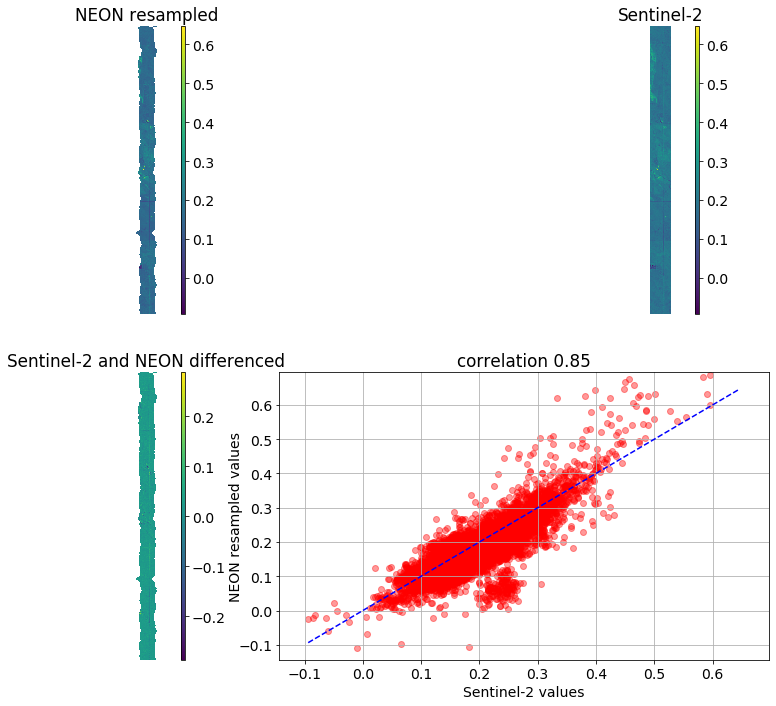

In [33]:
# plot Sentinel-2 8 ndvi for AOIs
for desc, neon_S2, og_S2 in zip(fl_gdf.filename.values[:num_fl], res_S2_means, S2_arrs):
    
    print(desc)
    # NEON NDVI
    neon_num = neon_S2.sel(sat_band='S2A_B8A') - neon_S2.sel(sat_band='S2A_B4')
    neon_den = neon_S2.sel(sat_band='S2A_B8A') + neon_S2.sel(sat_band='S2A_B4')
    neon_ndvi = neon_num / neon_den
    
    # Satellite NDVI
    s2_nir = 8 # 1-based... 7 or 8 for band 8 or 8a
    s2_red = 3 # 1-based
    sat_num = og_S2.sel(band=s2_nir) - og_S2.sel(band=s2_red)
    sat_den = og_S2.sel(band=s2_nir) + og_S2.sel(band=s2_red)
    sat_ndvi = (sat_num.astype('float')) / (sat_den.astype('float'))
    
    ## check shapes. if less than 2x2, fuhgeddaboutit
    neon_vals = np.flipud(neon_ndvi.values)
    sat_vals = sat_ndvi.values
    
    # hard threshold bad values
#     neon_vals[neon_vals>1] = 1
#     neon_vals[neon_vals<-1] = 1
    
#     # hard threshold bad values
#     sat_vals[sat_vals>1] = 1
#     sat_vals[sat_vals<-1] = 1
    
    neon_shape = neon_vals.shape
    sat_shape = sat_vals.shape
    
    if 1 in np.array([neon_shape] + [sat_shape]):
        print('array is too small for anything, continuing...')
        continue
    
    # slice if necessary
    if neon_shape[0] < sat_shape[0]:
        sat_vals = sat_vals[:neon_shape[0],:]
            
    if neon_shape[1] < sat_shape[1]:
        sat_vals = sat_vals[:, :neon_shape[1]]
        
    if neon_shape[0] > sat_shape[0]:
        neon_vals = neon_vals[:sat_shape[0],:]
            
    if neon_shape[1] > sat_shape[1]:
        neon_vals = neon_vals[:, :sat_shape[1]]
    
    # get the correlation coefficient
    corr = np.ma.corrcoef(np.ma.masked_invalid(neon_vals.flatten()), np.ma.masked_invalid(sat_vals.flatten()))[0,1]
    
    # plot the NDVI
    minval = min(sat_vals.min(), neon_vals.min())
    maxval = max(sat_vals.max(), neon_vals.max())
    
    fig, ax = plt.subplots(2,2, figsize=(15,10), constrained_layout=True)
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    
    im = ax[0,0].imshow(neon_vals, vmin=minval, vmax=maxval)
    fig.colorbar(im, ax=ax[0,0], aspect=75)
    ax[0,0].set_title('NEON resampled')
    ax[0,0].axis('off')
    
    im = ax[0,1].imshow(sat_vals, vmin=minval, vmax=maxval)
    fig.colorbar(im, ax=ax[0,1], aspect=75)
    ax[0,1].set_title('Sentinel-2')
    ax[0,1].axis('off')
    
    im = ax[1,0].imshow(sat_vals - neon_vals)
    fig.colorbar(im, ax=ax[1,0], aspect=75)
    ax[1,0].set_title('Sentinel-2 and NEON differenced')
    ax[1,0].axis('off')
    
    ax[1,1].scatter(sat_vals.flatten(), neon_vals.flatten(), alpha=0.4, color='r')
    ax[1,1].set_xlabel('Sentinel-2 values')
    ax[1,1].set_ylabel('NEON resampled values', labelpad=-5)
    ax[1,1].set_title(f'correlation {corr:0.2f}')
    
    ## plot 1:1 line
    ax[1,1].plot([minval, maxval], [minval, maxval], 'b--')
    ax[1,1].grid('on')
    
    
    ax[1,1].set_xlim(minval - 0.05, maxval + 0.05)
    ax[1,1].set_ylim(minval - 0.05, maxval + 0.05)
    
    
    plt.savefig('S2_NIS_NEON_NDVI.png', dpi=200)
    
    plt.show()

In [23]:
og_S2.band.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [24]:
sat_ndvi.rio.to_raster("test_s2_ndvi.tif")
neon_ndvi.rio.to_raster("test_NEON_ndvi.tif")

In [25]:
og_S2.sel(band=s2_nir).rio.to_raster("test_s2_nir.tif")
og_S2.sel(band=s2_red).rio.to_raster("test_s2_red.tif")
neon_S2.sel(sat_band='S2A_B8A').rio.to_raster("test_NEON_S2_nir.tif")
neon_S2.sel(sat_band='S2A_B4').rio.to_raster("test_NEON_S2_red.tif")

# Look at the band means and plot the difference map as function of variance or STD

In [26]:
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Sentinel-2

In [27]:
n_s2_ids = neon_S2.sat_band.values[[1,2,3,4,5,6,7,8,11,12]]
n_s2_ids

array(['S2A_B2', 'S2A_B3', 'S2A_B4', 'S2A_B5', 'S2A_B6', 'S2A_B7',
       'S2A_B8', 'S2A_B8A', 'S2A_B11', 'S2A_B12'], dtype='<U7')

NEON_D10_CPER_DP1_20200913_170936_reflectance
S2A_B2 1


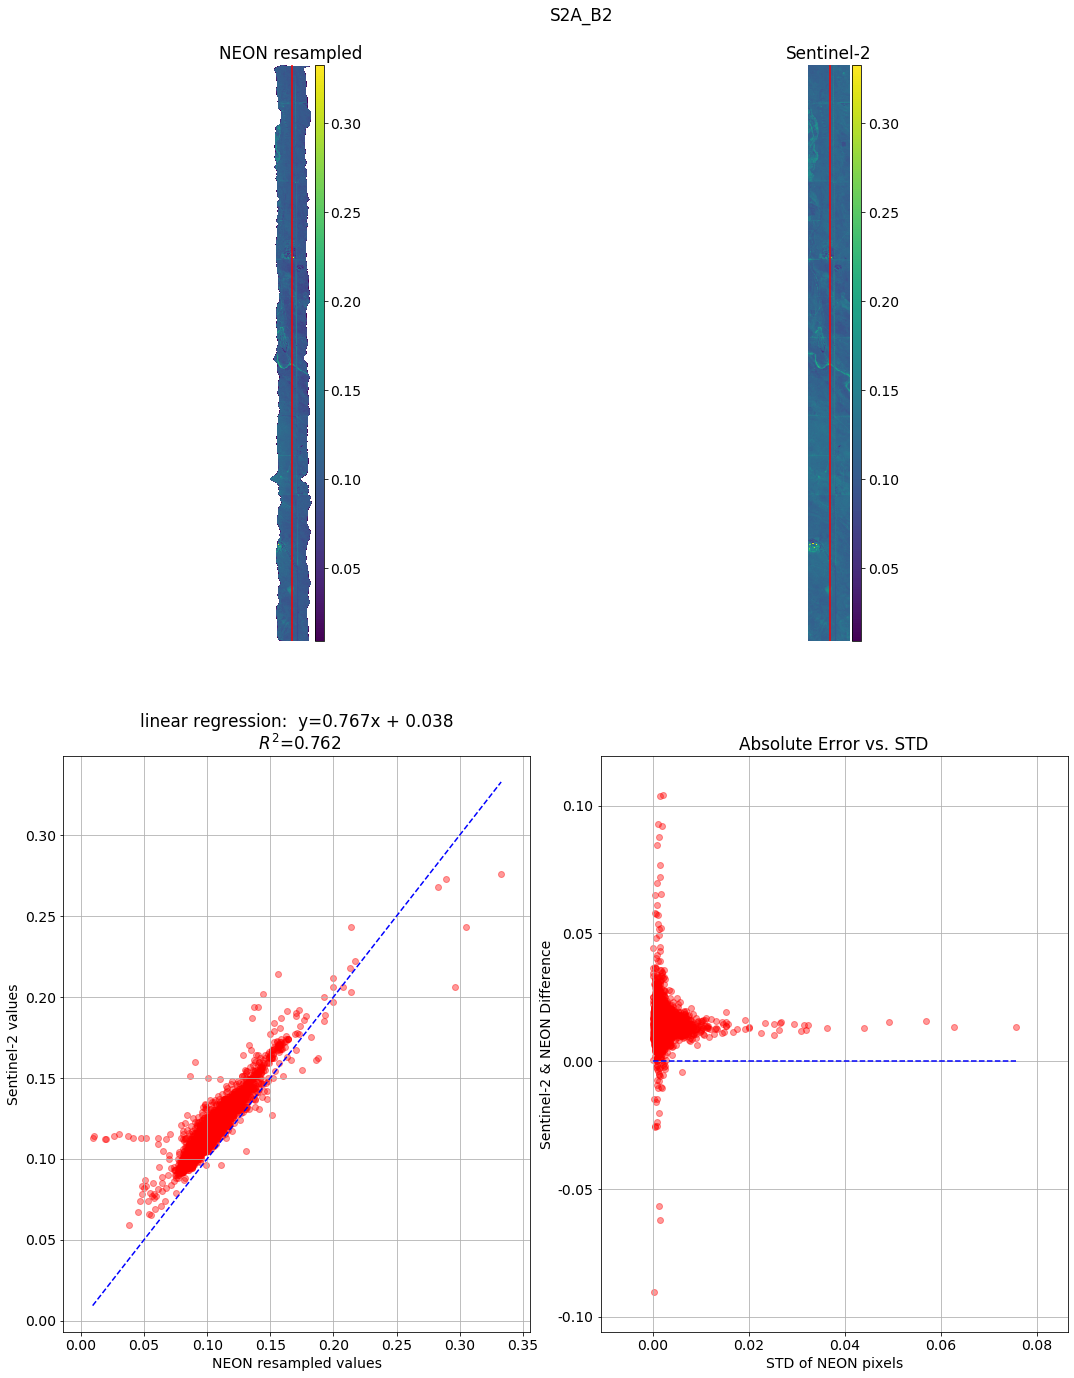

S2A_B3 2


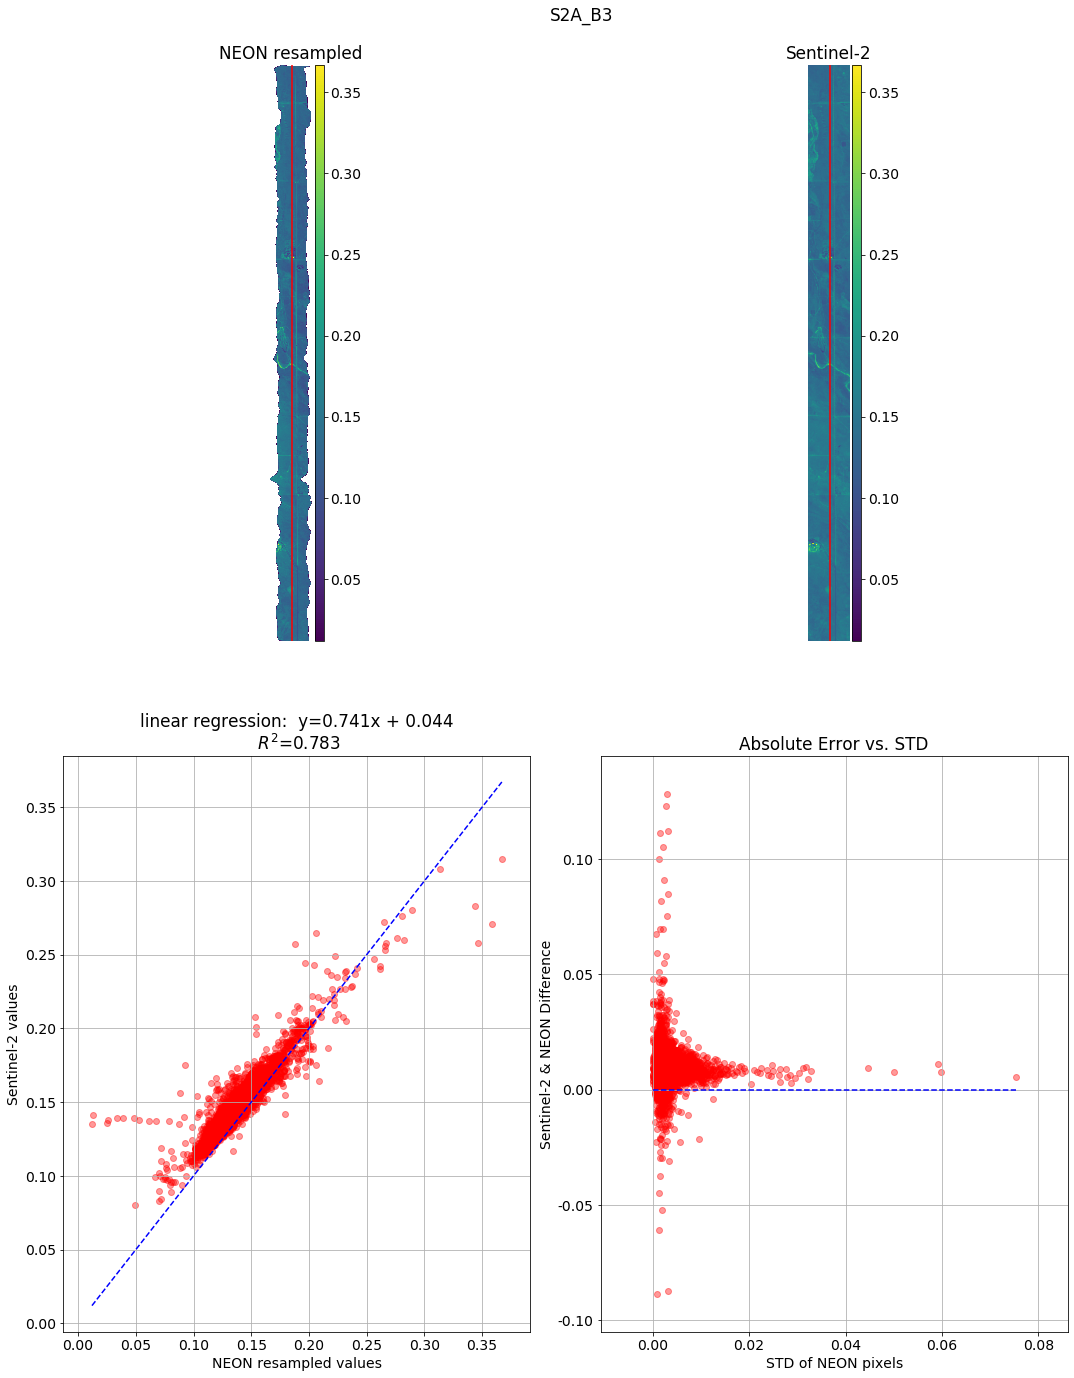

S2A_B4 3


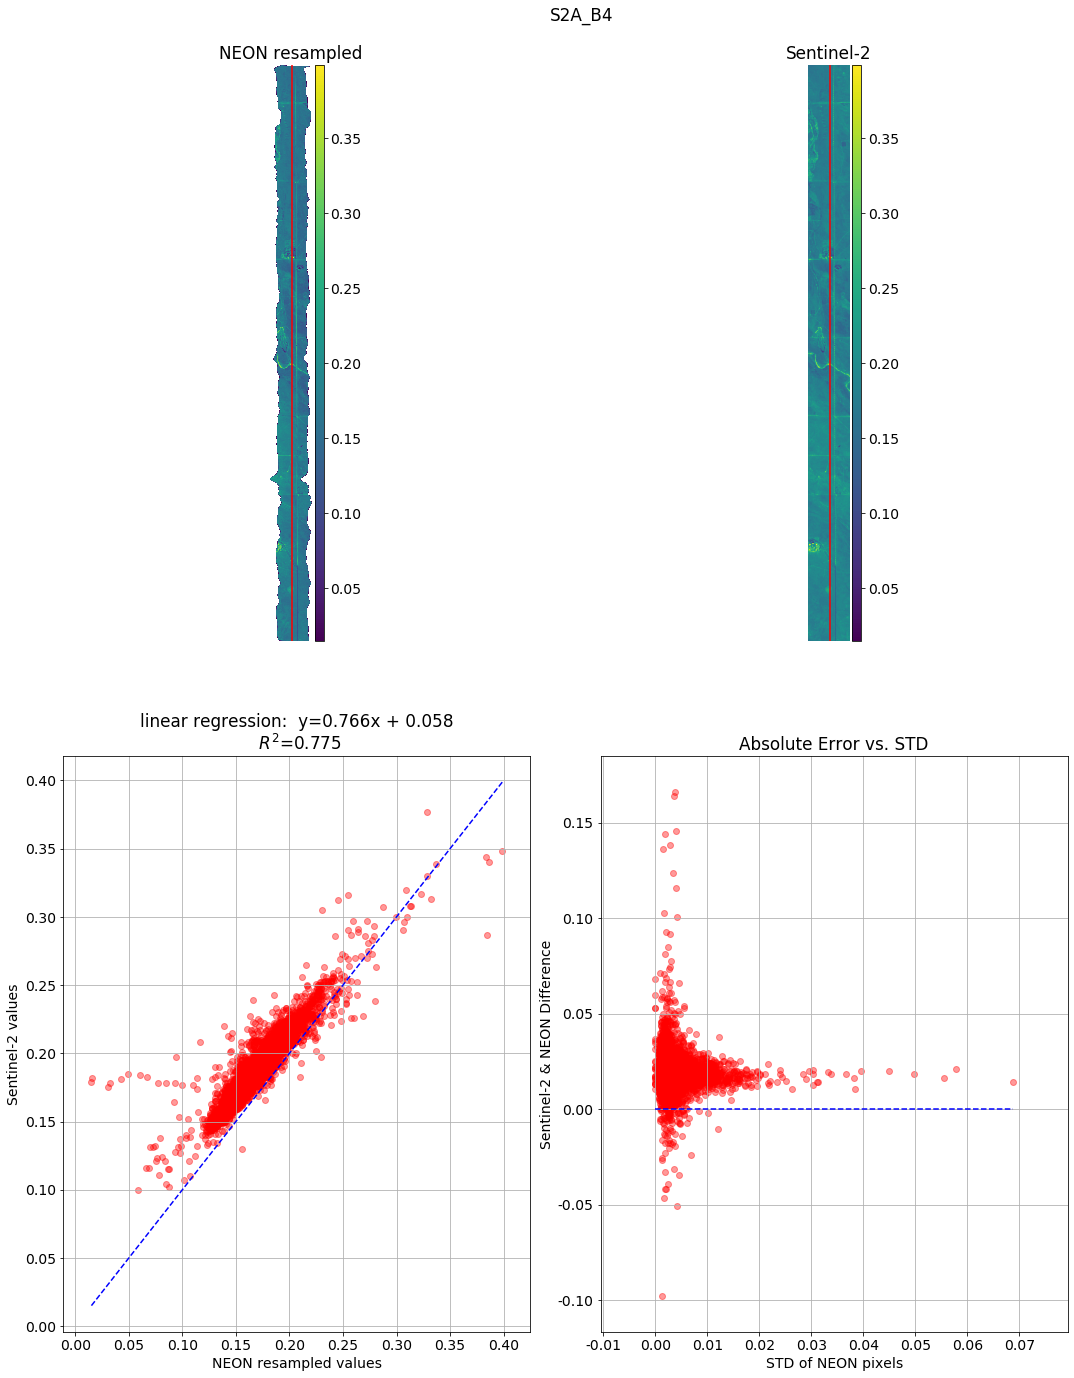

S2A_B5 4


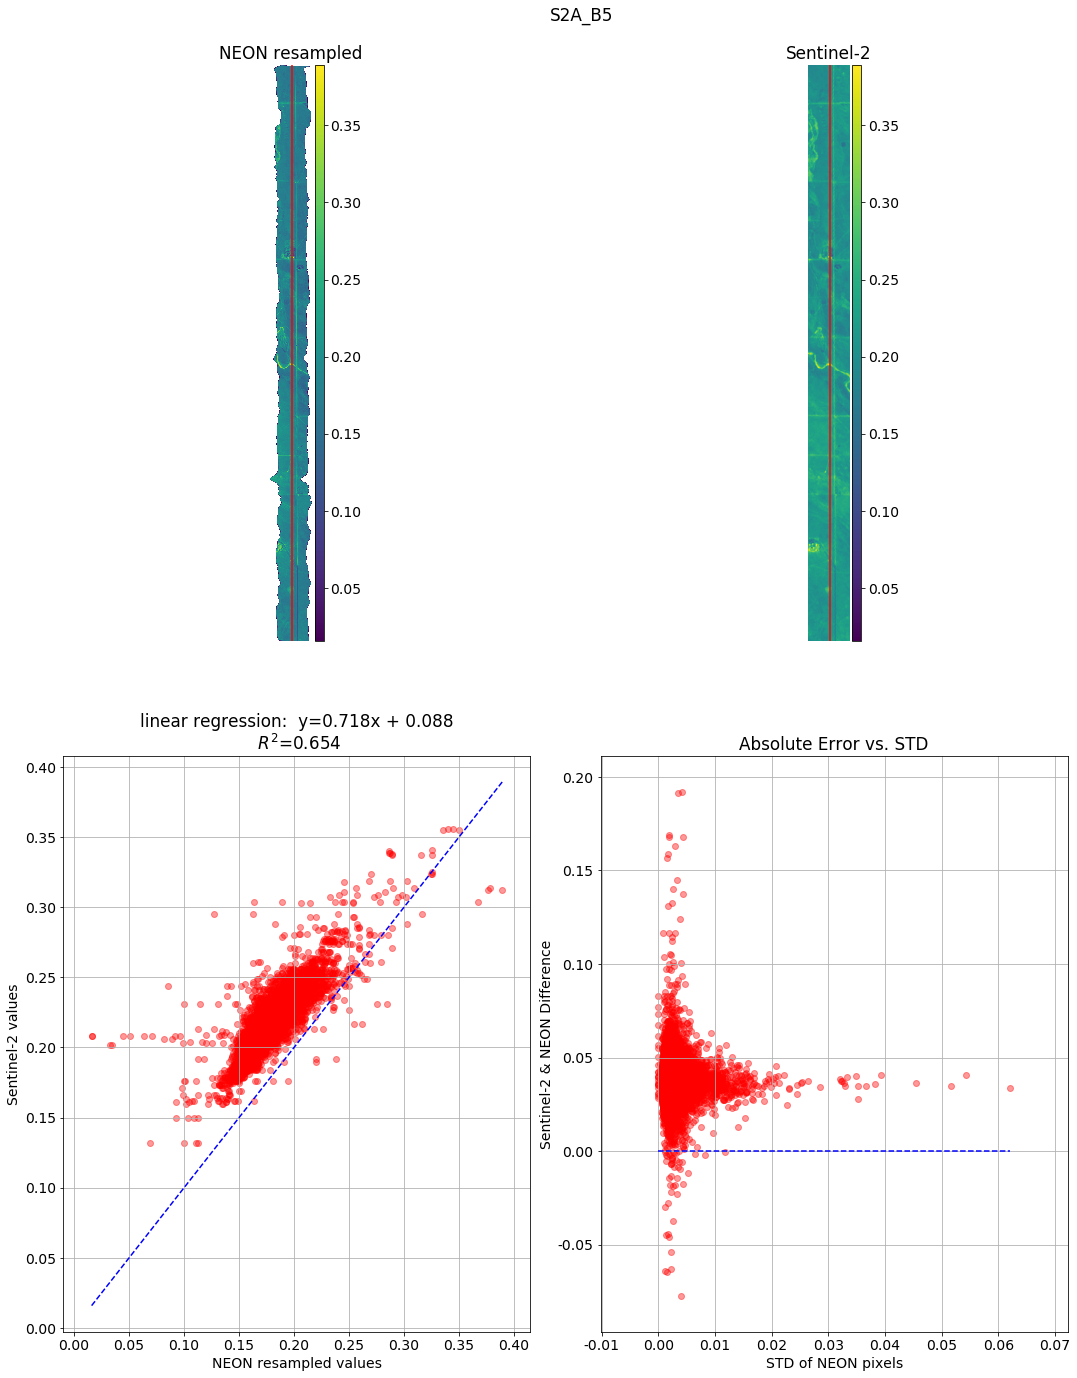

S2A_B6 5


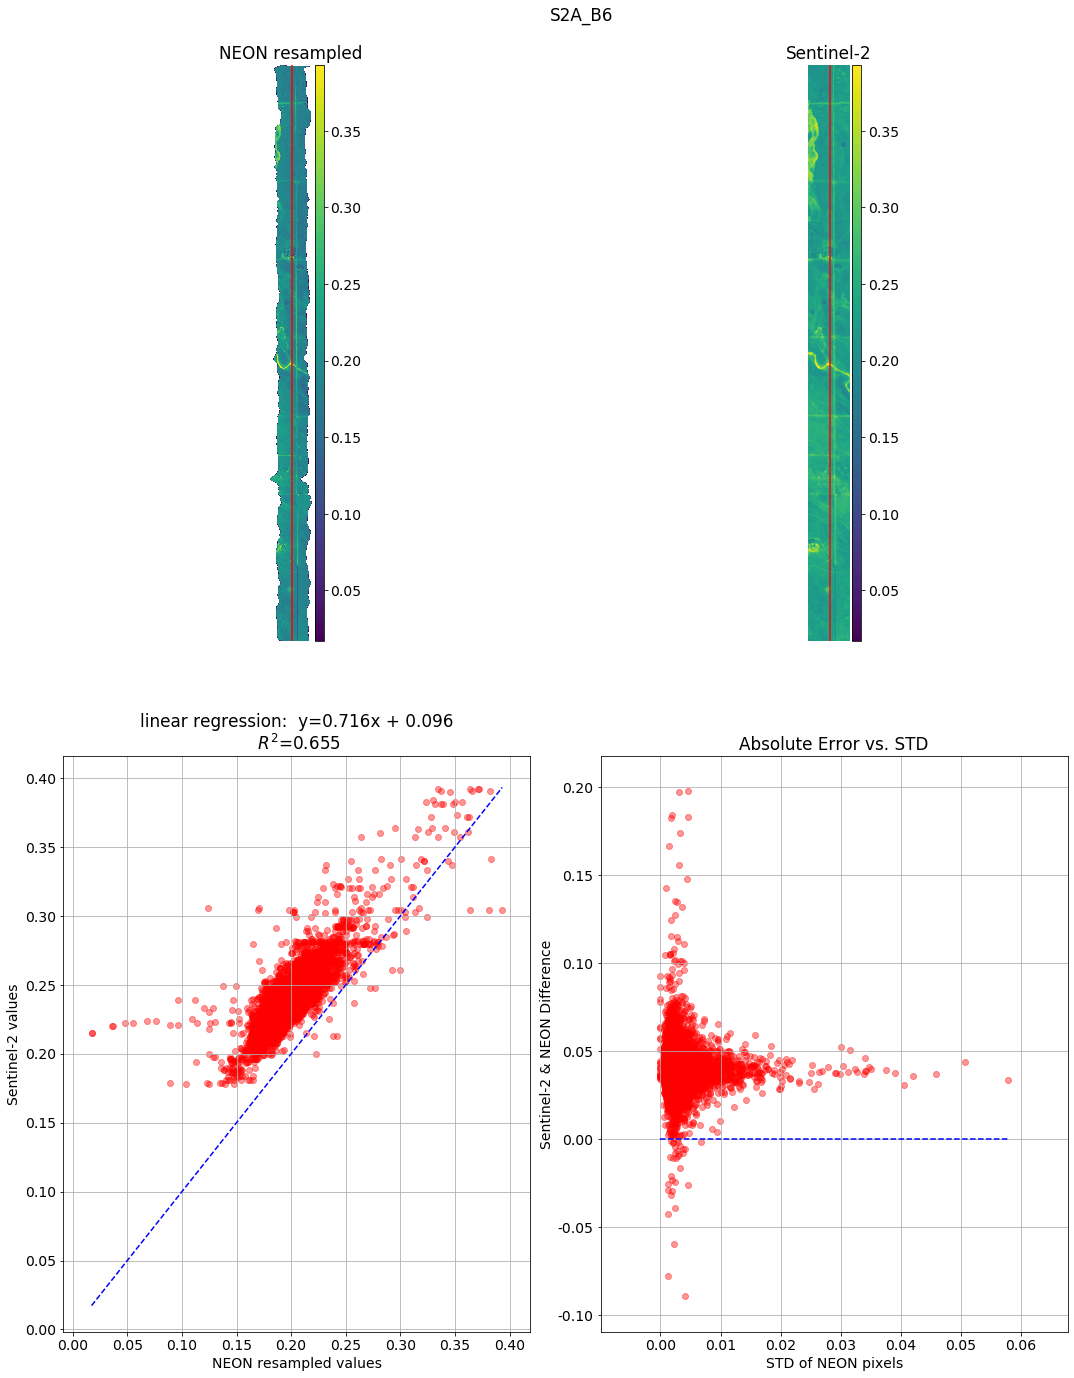

S2A_B7 6


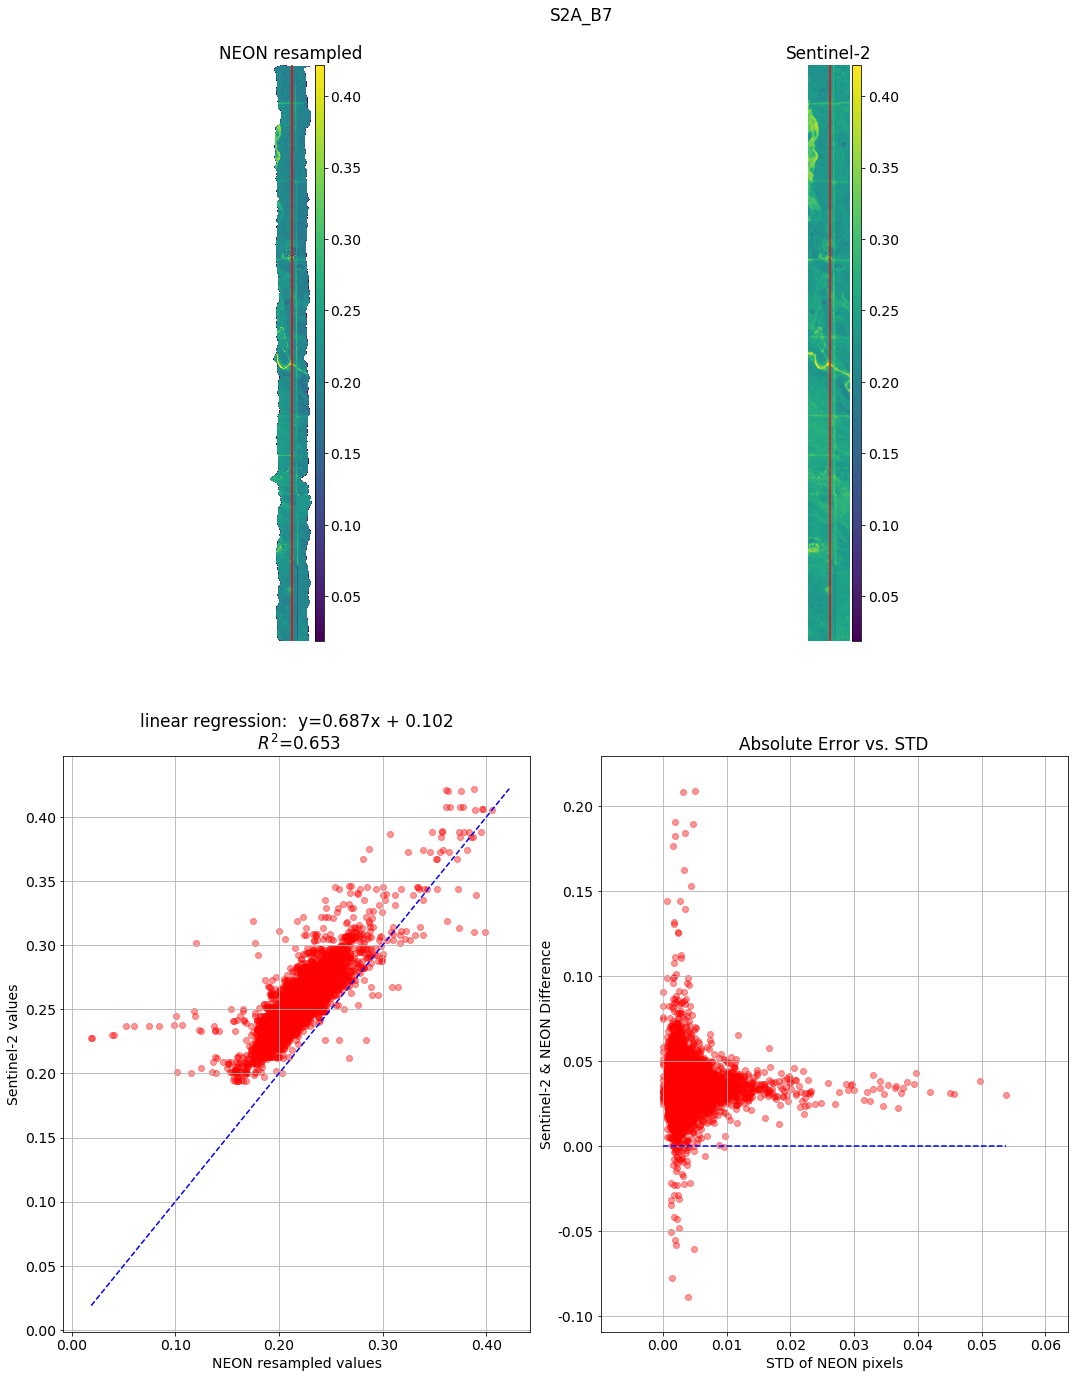

S2A_B8 7


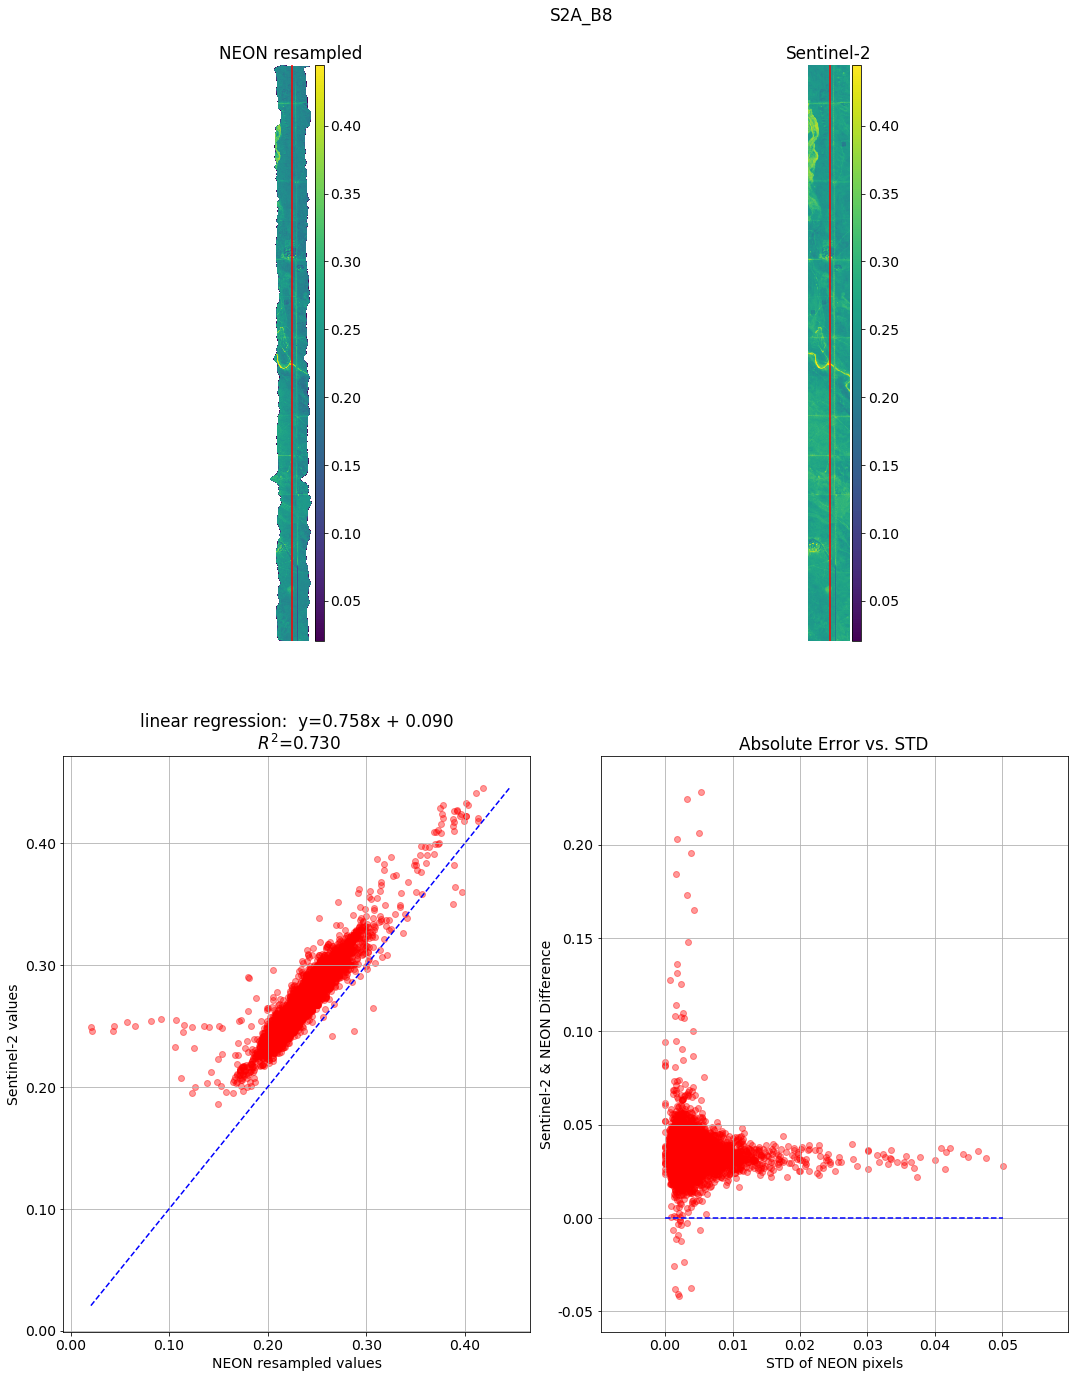

S2A_B8A 8


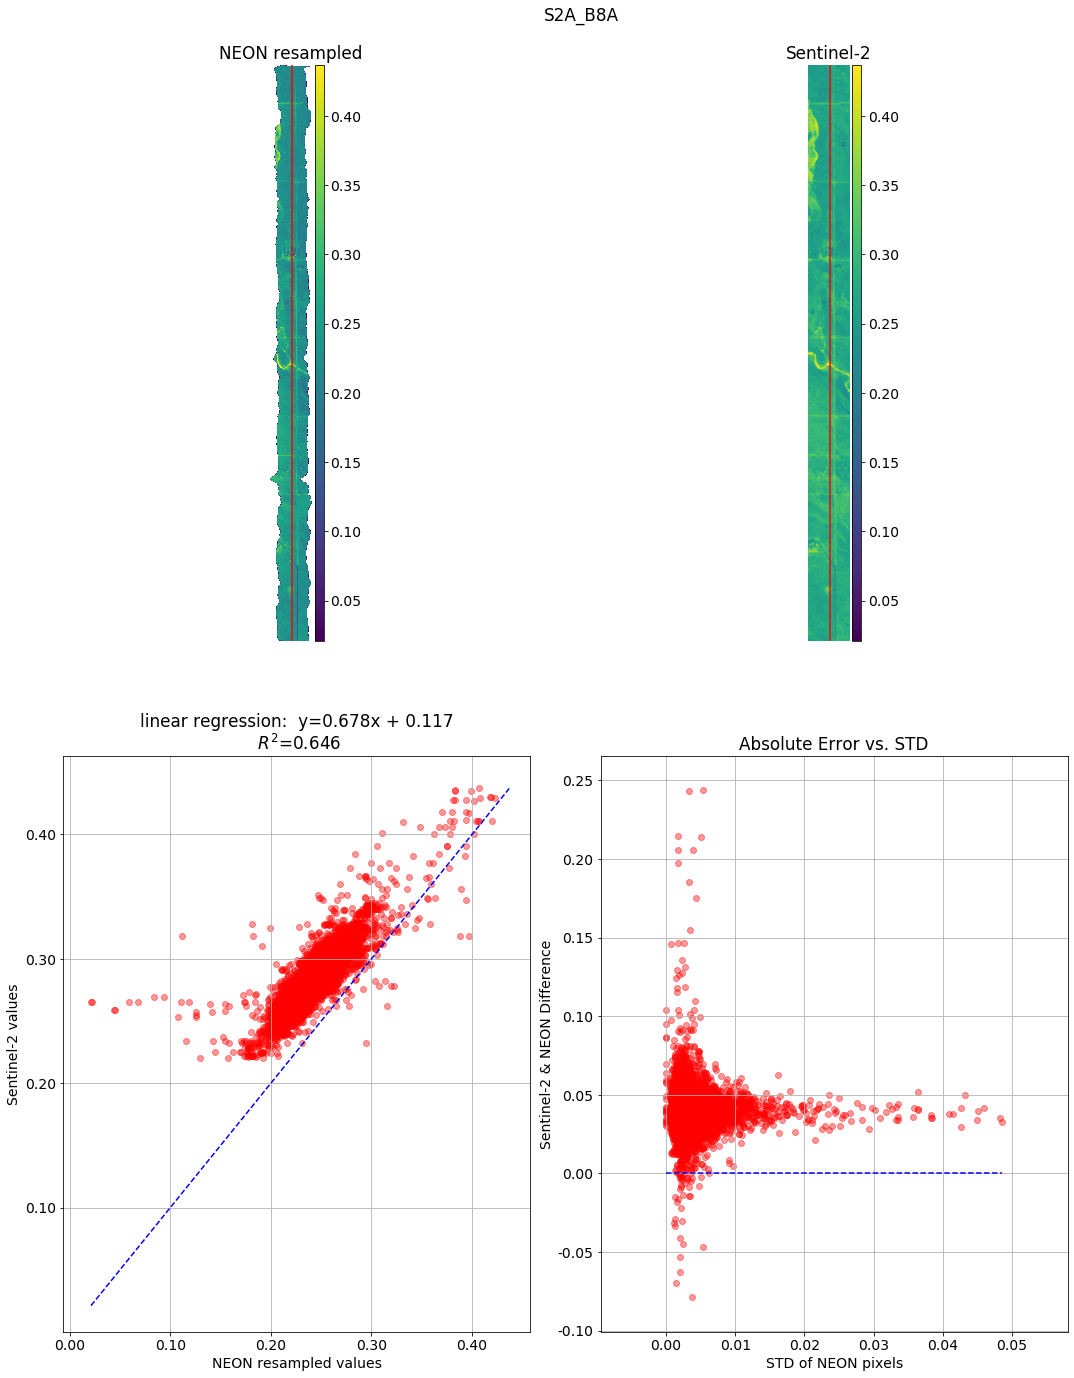

S2A_B11 9


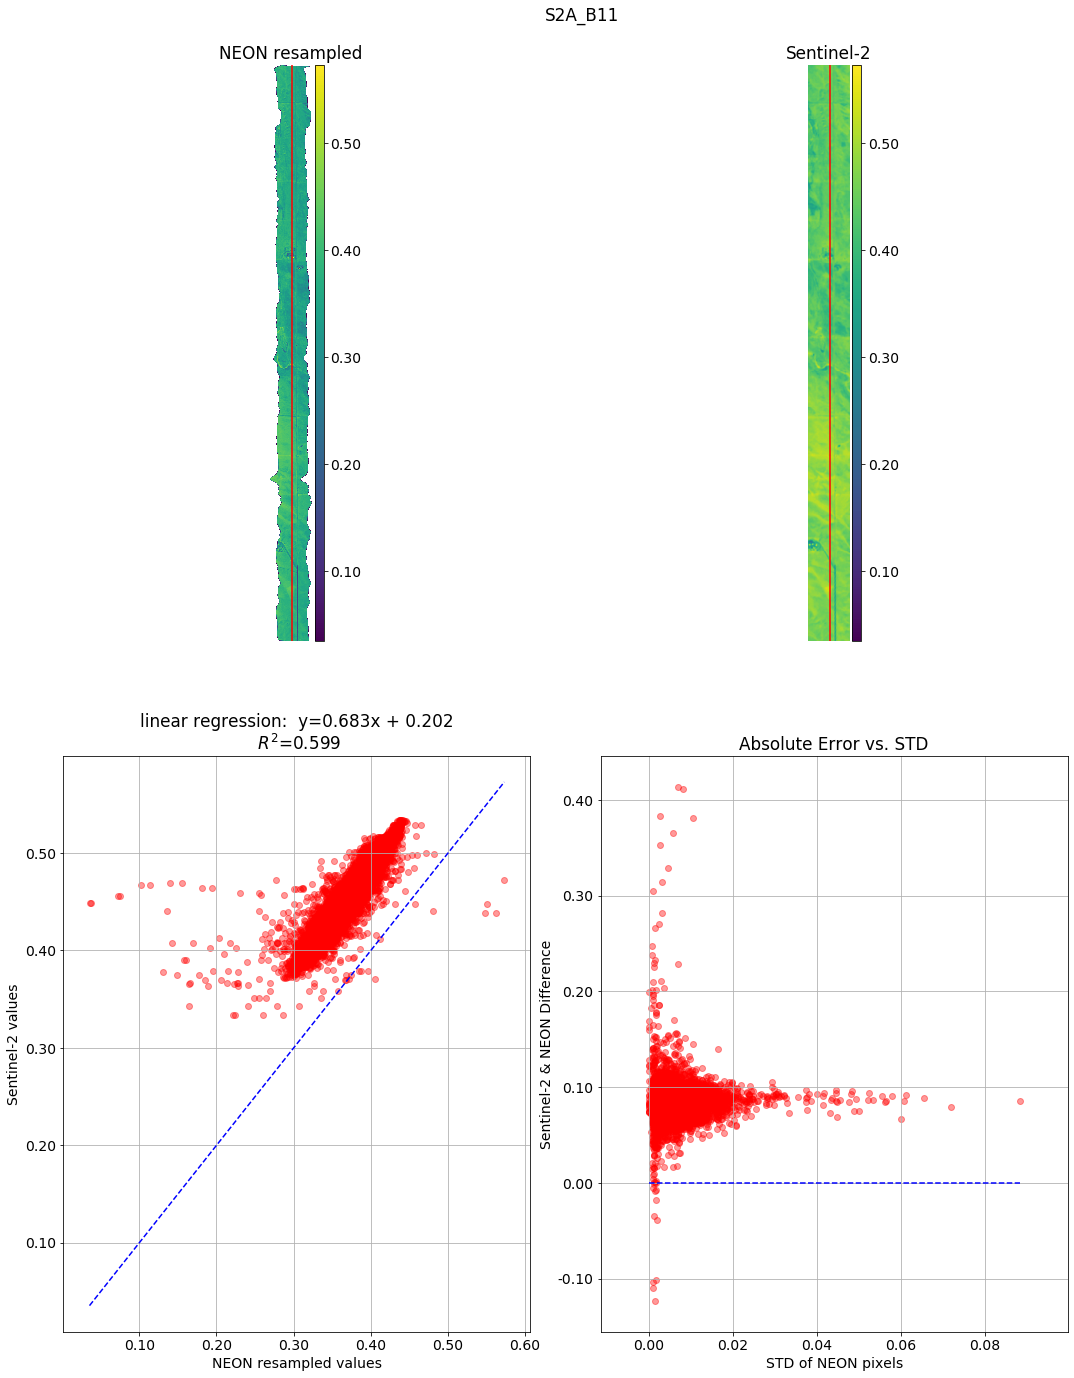

S2A_B12 10


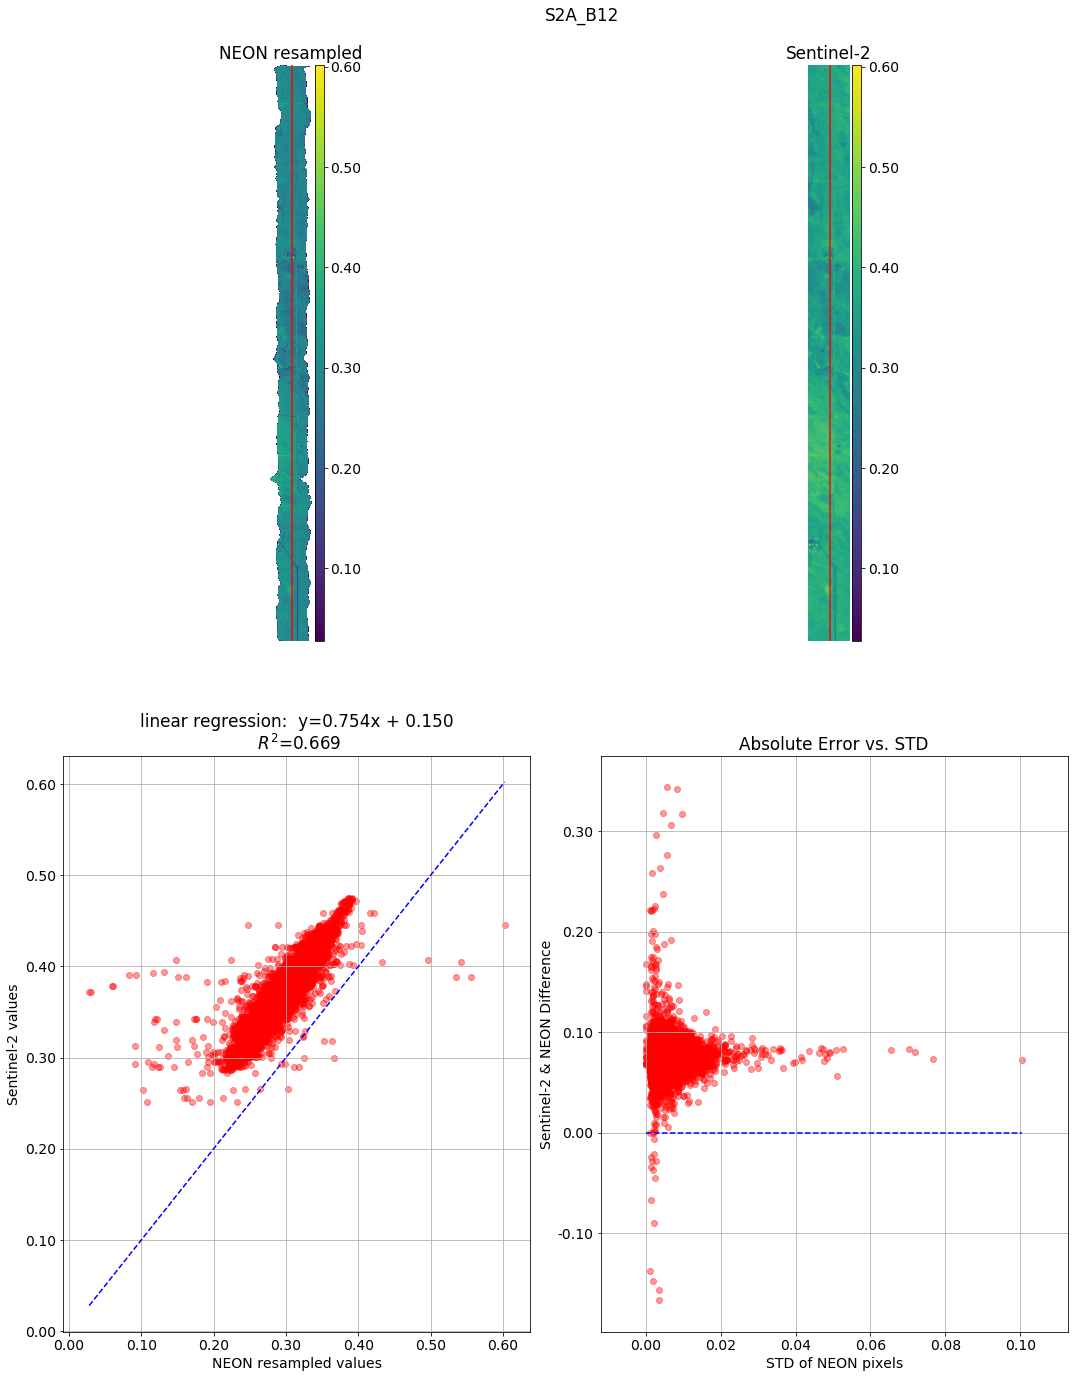

In [28]:
# plot Sentinel-2 8 ndvi for AOIs

# need to iterate through the correct bands for sentinel 2, as arcsi produces only 10m and 20m bands and omits the 60m
for desc, neon_S2, og_S2, neon_S2_std in zip(fl_gdf.filename.values[:num_fl], res_S2_means, S2_arrs, res_S2_stds):
    
    print(desc)
    if 'tarp' in desc:
        print('tarp is too small, skip it...')
        continue
        
    # iterate through the bands
    n_s2_ids = neon_S2.sat_band.values[[1,2,3,4,5,6,7,8,11,12]]
    for nband, sband in zip(n_s2_ids, og_S2.band.values):
        print(nband, sband)
        
        # select the bands from the data
        neon_band = neon_S2.sel(sat_band=nband)
        satl_band = og_S2.sel(band=sband).astype('float') #arcsi scale factor is 1000
        neon_std = neon_S2_std.sel(sat_band=nband)
        
        # extract values
        neon_band_vals = np.flipud(neon_band.values)
        satl_band_vals = satl_band.values
        neon_std_vals = neon_std.values
        
        # mask bad values
        neon_band_vals = np.ma.masked_greater(neon_band_vals, 1)
        satl_band_vals = np.ma.masked_greater(satl_band_vals, 1)
        
        # mask bad values
        neon_band_vals = np.ma.masked_less_equal(neon_band_vals, 0)
        satl_band_vals = np.ma.masked_less_equal(satl_band_vals, 0)
        
        # get shapes
        neon_shape = neon_band_vals.shape
        sat_shape = satl_band_vals.shape

        # if shape is too small, don't plot it
        if 1 in np.array([neon_shape] + [sat_shape]):
            print('array is too small for anything, continuing...')
            continue

        # slice if necessary
        if neon_shape[0] < sat_shape[0]:
            satl_band_vals = satl_band_vals[:neon_shape[0],:]

        if neon_shape[1] < sat_shape[1]:
            satl_band_vals = satl_band_vals[:, :neon_shape[1]]

        if neon_shape[0] > sat_shape[0]:
            neon_band_vals = neon_band_vals[:sat_shape[0],:]
            neon_std_vals = neon_std_vals[:sat_shape[0], :]

        if neon_shape[1] > sat_shape[1]:
            neon_band_vals = neon_band_vals[:, :sat_shape[1]]
            neon_std_vals = neon_std_vals[:, :sat_shape[1]]


        # linear regression piece
        #x = np.ma.masked_invalid(neon_band_vals.flatten())
        #y = np.ma.masked_invalid(satl_band_vals.flatten())
        
        # plot a profile instead
        idx=45
        buffer = 6
        start = idx-buffer
        end = idx+buffer
        n_prof = neon_band_vals[:, start:end]
        s_prof = satl_band_vals[:, start:end]


        # linear regression piece
        x = np.ma.masked_invalid(n_prof.flatten())
        y = np.ma.masked_invalid(s_prof.flatten())
        slope, intercept, r, p, se = linregress(x, y)
        
        
        # get the correlation coefficient
        #corr = np.ma.corrcoef(np.ma.masked_invalid(neon_band_vals.flatten()), 
         #                     np.ma.masked_invalid(satl_band_vals.flatten()))[0,1]
    
        ############### PLOTTING ##################
        minval = min(x.min(), y.min())
        maxval = max(x.max(), y.max())

        # plot the images and scatter plots
        fig, ax = plt.subplots(2,2, figsize=(15,20))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.15)

        ## NEON resampled band
        im = ax[0,0].imshow(neon_band_vals, vmin=minval, vmax=maxval)

        divider = make_axes_locatable(ax[0,0])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))

        #fig.colorbar(im, ax=ax[0,0])
        ax[0,0].axvline(idx, c='r')
        ax[0,0].set_title('NEON resampled')
        ax[0,0].axis('off')
        

        ## Satellite band
        im = ax[0,1].imshow(satl_band_vals, vmin=minval, vmax=maxval)

        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.2f'))

        #fig.colorbar(im, ax=ax[0,1])
        ax[0,1].axvline(idx, c='r')
        ax[0,1].set_title('Sentinel-2')
        ax[0,1].axis('off')

        ## Scatter plot of resampled NEON mean value and satellite band
        #im = ax[1,0].scatter(neon_band_vals.flatten(), satl_band_vals.flatten(), alpha=0.4, color='r')
        im = ax[1,0].scatter(x, y, alpha=0.4, color='r')
        ax[1,0].set_title('Sentinel-2 vs. NEON means')
        ax[1,0].set_ylabel('Sentinel-2 values')
        ax[1,0].set_xlabel('NEON resampled values')
        ax[1,0].set_title(f'linear regression:  y={slope:0.3f}x + {intercept:0.3f}\n $R^2$={r**2:0.3f}')

        ## plot 1:1 line
        minval = min(x.min(), y.min())
        maxval = max(x.max(), y.max())
        ax[1,0].plot([minval, maxval], [minval, maxval], 'b--')

        ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,0].grid('on')

        ## Scatter plot of difference values vs. std for that pixel
        spectral_dif = satl_band_vals.flatten() - neon_band_vals.flatten()
        spectral_dif = y-x
        ax[1,1].scatter(neon_std_vals[:,start:end].flatten(), spectral_dif, alpha=0.4, color='r')
        #ax[1,1].scatter(neon_std_vals.flatten(), spectral_dif, alpha=0.4, color='r')
        ax[1,1].set_ylabel('Sentinel-2 & NEON Difference')
        ax[1,1].set_xlabel('STD of NEON pixels')
        ax[1,1].set_title(f'Absolute Error vs. STD')
        ax[1,1].grid('on')

        ## plot zero line line
        minval = neon_std_vals[:,start:end].min()
        maxval = neon_std_vals[:,start:end].max()
        ax[1,1].plot([minval, maxval], [0,0], 'b--')

        ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


        fig.suptitle(nband)
        
        plt.savefig(f'S2_NIS_band_{nband}.png', dpi=200)
        plt.show()
        
    break

Check the band of values < 0.2

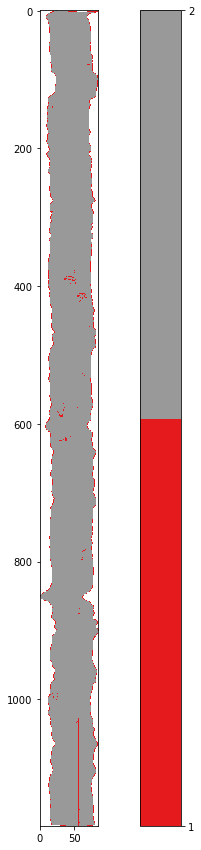

In [15]:
temp = np.ma.where(neon_band_vals < 0.2, 1, 2)
plt.figure(figsize=(15,15))
cmap = plt.get_cmap('Set1', 2)
plt.imshow(temp, cmap=cmap)
plt.colorbar(ticks=[1,2])
plt.show()

In [16]:
type(neon_vals)

numpy.ndarray